Short example of usage for generating and analyzing the propagator for frequency conversion, for an unpoled waveguide.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from FC_solve_EoM import get_prop, get_JCA, get_schmidt, get_schmidt2, pulse_shape, remove_phases
%config InlineBackend.figure_formats=['svg']
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=170)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We begin by defining the parameters associated with frequency conversion (of the pump and crystal).

In [22]:
vc, vp, va = 1 / 1.5, 1 / 3, 1 / 4.5  # group velocities

dw_range = 10  # Range of frequency values
N = 301 # Number of frequency points
dw = np.linspace(-dw_range, dw_range, N)  # Frequency vector
L = 1.35  # Length of propagation in FC medium
sig = 1.1  # Width of the (Hermite-Gaussian) pump shape
amp = 0.08 # Pump amplitude
pump = amp * pulse_shape(dw[:, np.newaxis] - dw, sig, n = 0)  # Gaussian-shaped pump

We then generate the propagator by calling the appropriate function.

In [23]:
_, prop = get_prop(dw, vp, va, vc, pump, L)  # Matrix to exponentiate and propagator

We can visualize the input pulses by defining them and comparing them to the pump pulse shape.

In [24]:
# Initial pulses
initial_Ea = np.zeros(dw.size)
initial_Ec = 0.05 * pulse_shape(dw, 1)

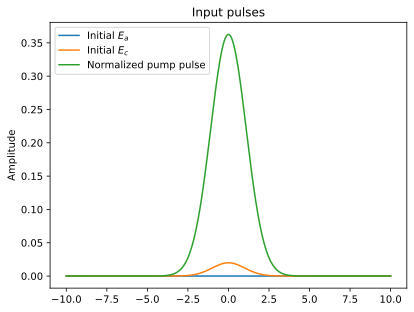

In [25]:
plt.plot(dw, initial_Ea, label="Initial $E_a$")
plt.plot(dw, initial_Ec, label="Initial $E_c$")
plt.plot(dw, pulse_shape(dw, sig), label="Normalized pump pulse")
plt.ylabel("Amplitude")
plt.title("Input pulses")
plt.legend(loc="upper left")


To get what the output pulses look like, we do matrix multiplication with the propagator, with its phases removed.

In [26]:
sol = remove_phases(prop, dw, L, vp, va, vc) @ np.concatenate((initial_Ea, initial_Ec))
Ea, Ec = np.split(sol, 2)

Text(0.5, 1.0, 'a beam / down-converted beam')

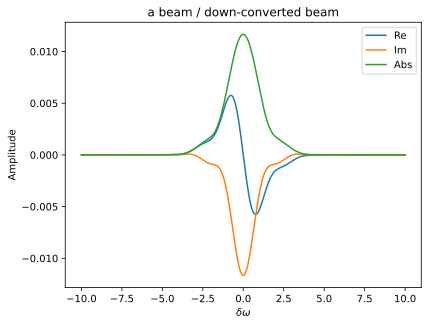

In [27]:
plt.plot(dw, np.real(Ea), label="Re")
plt.plot(dw, np.imag(Ea), label="Im")
plt.plot(dw, np.abs(Ea), label="Abs")
plt.legend()
plt.xlabel("$\delta\omega$")
plt.ylabel("Amplitude")
plt.title("a beam / down-converted beam")

Text(0.5, 1.0, 'c beam / non-converted beam')

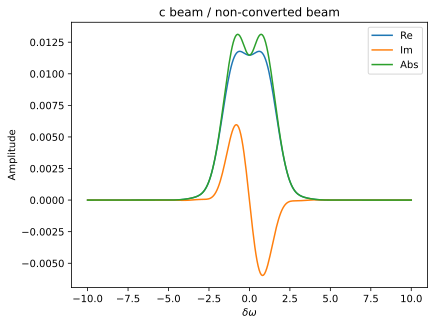

In [28]:
plt.plot(dw, np.real(Ec), label="Re")
plt.plot(dw, np.imag(Ec), label="Im")
plt.plot(dw, np.abs(Ec), label="Abs")
plt.legend()
plt.xlabel("$\delta\omega$")
plt.ylabel("Amplitude")
plt.title("c beam / non-converted beam")

To get the Joint Conversion Amplitude, we call the appropriate function and show the matrix.

In [29]:
J = get_JCA(prop)

Text(0, 0.5, '$\\delta\\omega_{out}$')

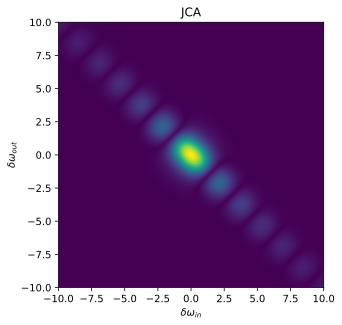

In [30]:
plt.imshow(np.abs(J), extent=[dw.min(), dw.max(), dw.min(), dw.max()])
plt.title("JCA")
plt.xlabel("$\delta\omega_{in}$")
plt.ylabel("$\delta\omega_{out}$")

To extract information from the propagator, we can do a Schmidt decomposition. This yields the same information as an eigendecomposition of the numbers matrix, which is what we do by calling `get_schmidt`. From the function, we get the average number of photons generated, the vector of eigenvalues (Schmidt coefficients squared) and the eigenvectors (Schmidt modes).

In [31]:
Na, val, u = get_schmidt(prop)
txt = "Average number of signal photons is {val:e}"
print(txt.format(val=Na))

Average number of signal photons is 7.046517e-01


We can then select a mode to plot. Here is the first mode.

Text(0.5, 1.0, 'Schmidt mode 1')

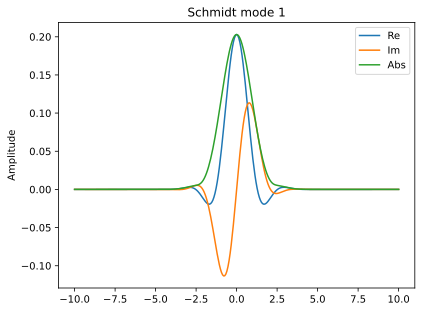

In [32]:
mark = 1 # number of the Schmidt mode to plot

mode = np.exp(-1j * np.angle(u[(N - 1) // 2, mark-1])) * u[:, mark-1] # applying a phase so that the imaginary part is 0 at 0
plt.plot(dw, np.real(mode), label="Re")
plt.plot(dw, np.imag(mode), label="Im")
plt.plot(dw, np.abs(mode), label="Abs")
plt.legend()
plt.ylabel("Amplitude")
plt.title("Schmidt mode " + str(mark))

We can also make a bar plot of the conversion efficiencies for each mode. Here we do the first 10 modes.

(0.0, 1.1)

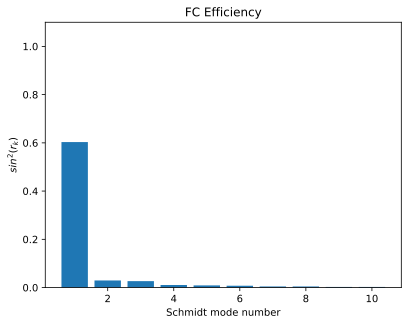

In [33]:
effs = val[:10] # efficiencies for the first 10 modes
plt.bar(x=np.arange(1, 11), height=effs)
plt.xlabel("Schmidt mode number")
plt.ylabel("$sin^2(r_k)$")
plt.title("FC Efficiency")
plt.ylim(0, 1.1)

To check that our results are good, we can also make use of the `get_schmidt2` function, which does the same Schmidt decomposition but by doing the SVDs directly.

In [34]:
u, val, *_ = get_schmidt2(prop)

Text(0.5, 1.0, 'Schmidt mode 1')

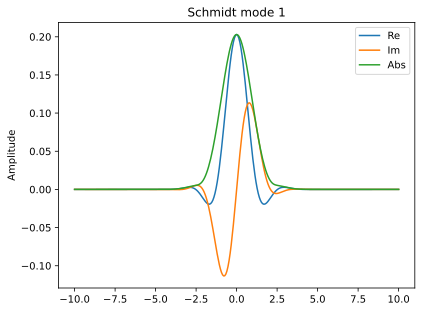

In [35]:
mark = 1 # number of the Schmidt mode to plot

mode = np.exp(-1j * np.angle(u[(N - 1) // 2, mark-1])) * u[:, mark-1] # applying a phase so that the imaginary part is 0 at 0
plt.plot(dw, np.real(mode), label="Re")
plt.plot(dw, np.imag(mode), label="Im")
plt.plot(dw, np.abs(mode), label="Abs")
plt.legend()
plt.ylabel("Amplitude")
plt.title("Schmidt mode " + str(mark))

(0.0, 1.1)

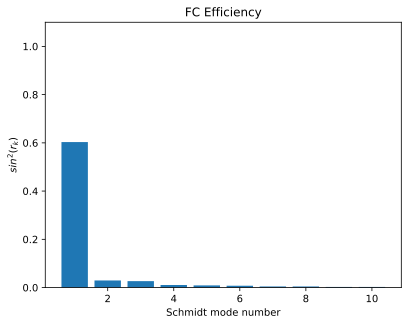

In [36]:
effs = val[:10]**2 # efficiencies for the first 10 modes. We square them because SVDs yield the Schmidt coefficients not squared.
plt.bar(x=np.arange(1, 11), height=effs)
plt.xlabel("Schmidt mode number")
plt.ylabel("$sin^2(r_k)$")
plt.title("FC Efficiency")
plt.ylim(0, 1.1)

As we can see, the SVD results match the eigendecomposition results.